In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft #stft
from scipy.signal import butter, sosfiltfilt #signal filtering 
from scipy.interpolate import interp1d
import numpy as npy
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#First EOC test, in chair holding phone up in front of me 
file_path = "EOC_Experiments/EyesOC_MuseCrocMobile_2025-10-16_21_02_50_MS_03_PRESET_1021_EEG@256Hz_Accelerometer@52Hz_Gyroscope@52Hz_DRL_REF@32Hz_.csv"

#Second EOC test, in chair holding phone up in front of me 
#file_path = "EOC_Experiments/EyesOC_MuseCrocMobile_2025-10-16_21_05_14_MS_03_PRESET_1021_EEG@256Hz_Accelerometer@52Hz_Gyroscope@52Hz_DRL_REF@32Hz_.csv"

#change to your file path
df = pd.read_csv(file_path)
df.head()

for col_name in df.columns:
    print(col_name)

print(df.shape)

#Setting font size to 25 for all graphs
plt.rcParams.update({'font.size': 25})

PACKET_TYPE
CLOCK_TIME
ms_ELAPSED
TRIGGER_COUNT
EXPERIMENT_STAGE
TP9_CONNECTION_STRENGTH(HSI)
TP9_ARTIFACT_FREE(IS_GOOD)
AF7_CONNECTION_STRENGTH(HSI)
AF7_ARTIFACT_FREE(IS_GOOD)
AF8_CONNECTION_STRENGTH(HSI)
AF8_ARTIFACT_FREE(IS_GOOD)
TP10_CONNECTION_STRENGTH(HSI)
TP10_ARTIFACT_FREE(IS_GOOD)
TP9_RAW
AF7_RAW
AF8_RAW
TP10_RAW
DRL
REF
TP9_DELTA_ABSOLUTE
AF7_DELTA_ABSOLUTE
AF8_DELTA_ABSOLUTE
TP10_DELTA_ABSOLUTE
TP9_THETA_ABSOLUTE
AF7_THETA_ABSOLUTE
AF8_THETA_ABSOLUTE
TP10_THETA_ABSOLUTE
TP9_ALPHA_ABSOLUTE
AF7_ALPHA_ABSOLUTE
AF8_ALPHA_ABSOLUTE
TP10_ALPHA_ABSOLUTE
TP9_BETA_ABSOLUTE
AF7_BETA_ABSOLUTE
AF8_BETA_ABSOLUTE
TP10_BETA_ABSOLUTE
TP9_GAMMA_ABSOLUTE
AF7_GAMMA_ABSOLUTE
AF8_GAMMA_ABSOLUTE
TP10_GAMMA_ABSOLUTE
TP9_DELTA_RELATIVE
AF7_DELTA_RELATIVE
AF8_DELTA_RELATIVE
TP10_DELTA_RELATIVE
TP9_THETA_RELATIVE
AF7_THETA_RELATIVE
AF8_THETA_RELATIVE
TP10_THETA_RELATIVE
TP9_ALPHA_RELATIVE
AF7_ALPHA_RELATIVE
AF8_ALPHA_RELATIVE
TP10_ALPHA_RELATIVE
TP9_BETA_RELATIVE
AF7_BETA_RELATIVE
AF8_BETA_RELATIVE
TP

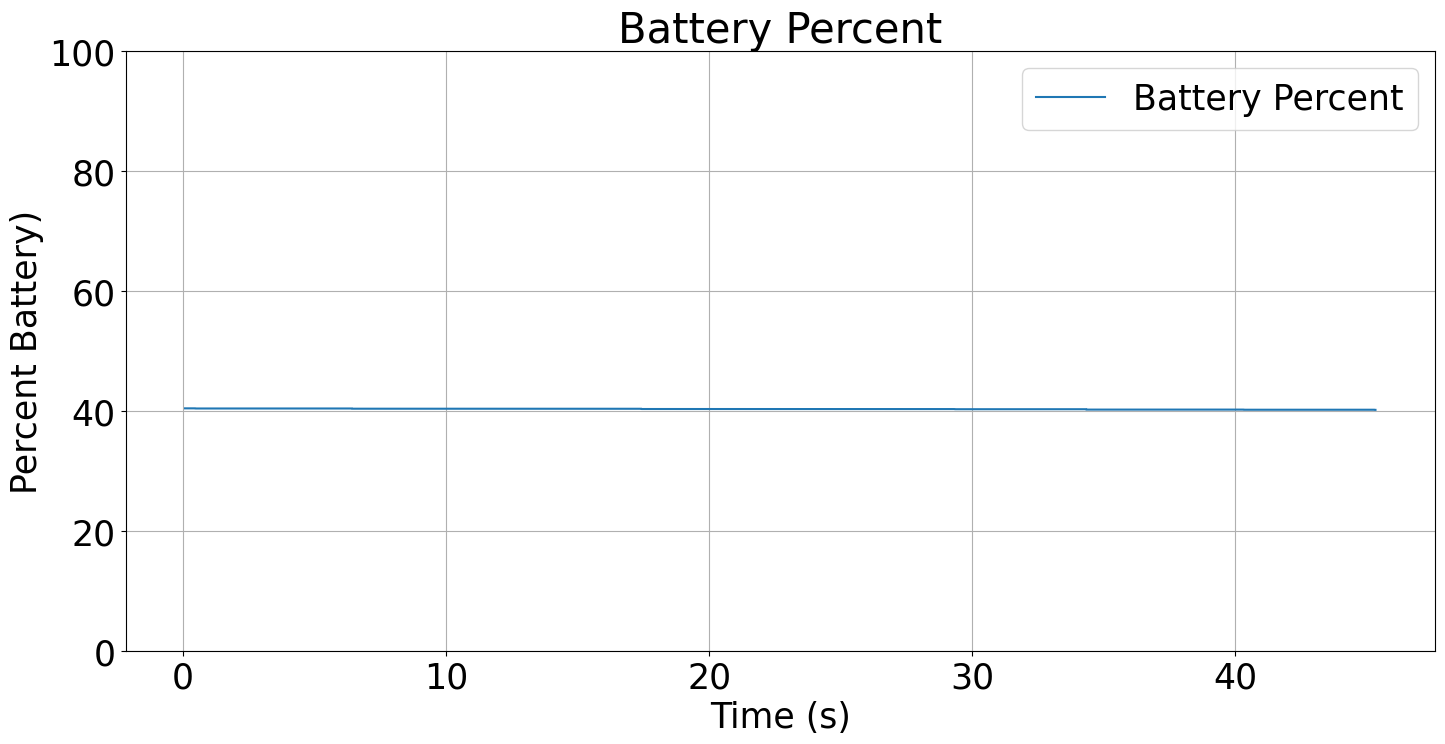

In [3]:
'''
Battery issues can cause the Muse to malfunction - check that!
'''

time_sec = df["ms_ELAPSED"] / 1000.0

plt.figure(figsize=(15, 8))
plt.plot(time_sec, df['BATTERY_PERCENT'], label="Battery Percent")

plt.ylim(0,100)

plt.xlabel("Time (s)")
plt.ylabel("Percent Battery)")
plt.title(f"Battery Percent")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
'''
Now, for accurate processing of raw EEG, 
we need to select values only from lines 
where packet type is EEG. This is to 
remove duplicate values and prevent / spot 
possible issues. 
'''

#prints packet types
print(df['PACKET_TYPE'].unique())

# Filter for raw EEG + time packet types only
eeg_df = df[df['PACKET_TYPE'] == 'EEG'][['ms_ELAPSED', 'TP9_RAW', 'AF7_RAW', 'AF8_RAW', 'TP10_RAW']].copy()

#get time in seconds of eeg df
eeg_df_time_sec = eeg_df["ms_ELAPSED"] / 1000.0

# Reset index for clean indexing
eeg_df = eeg_df.reset_index(drop=True)

print(f"Original dataframe shape: {df.shape}")
print(f"EEG-only dataframe shape: {eeg_df.shape}")
eeg_df.head()


['ACCELEROMETER' 'GYRO' 'EEG' 'ALPHA_ABSOLUTE' 'BETA_ABSOLUTE'
 'DELTA_ABSOLUTE' 'THETA_ABSOLUTE' 'GAMMA_ABSOLUTE' 'ALPHA_RELATIVE'
 'BETA_RELATIVE' 'DELTA_RELATIVE' 'THETA_RELATIVE' 'GAMMA_RELATIVE'
 'IS_GOOD' 'HSI_PRECISION' 'DRL_REF']
Original dataframe shape: (23066, 66)
EEG-only dataframe shape: (11648, 5)


,ms_ELAPSED,TP9_RAW,AF7_RAW,AF8_RAW,TP10_RAW
0,89,722.743087,728.673015,721.238479,748.763963
1,90,721.858024,722.920100,724.070683,732.301776
2,90,721.769517,720.441922,725.309772,712.741867
3,91,719.822377,719.999390,722.389062,720.353415
4,91,722.566075,720.707441,721.415492,738.143197


Original dataframe shape: (23066, 66)
Optics-only dataframe shape: (11648, 6)

Total Recording time in ms: 45330
Total Recording time in s: 45.33
Number of samples: 11648

Expected number of samples (ms precision): 11604.48

Write Timing Stats: 

count    11647.000000
mean         3.884348
std         12.497849
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        173.000000
Name: ms_diff, dtype: float64


Expected Mean ms Between Writes : 3.90625

Actual Mean ms between: 3.8843479007469734
Max ms between: 173.0


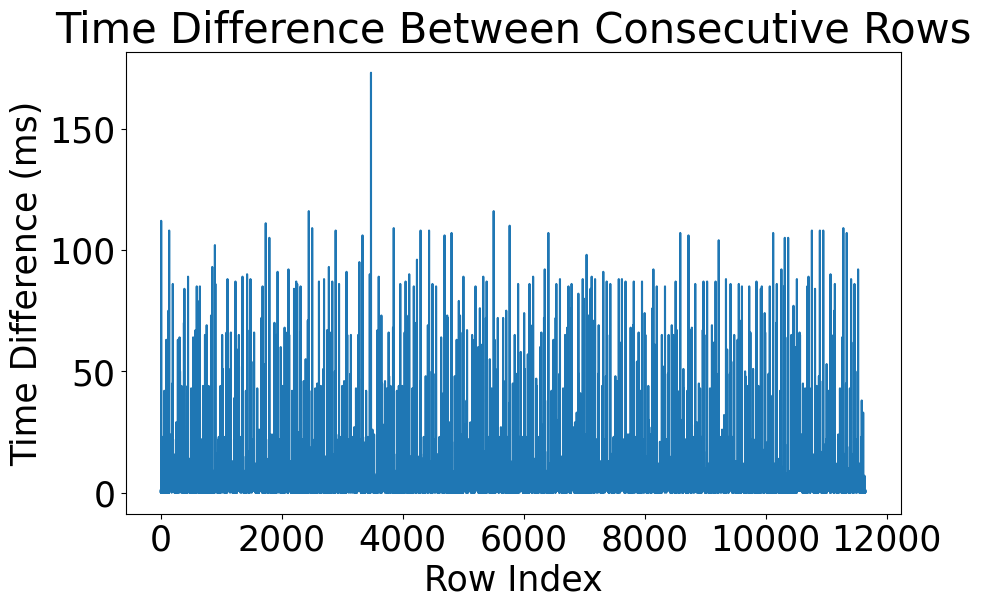

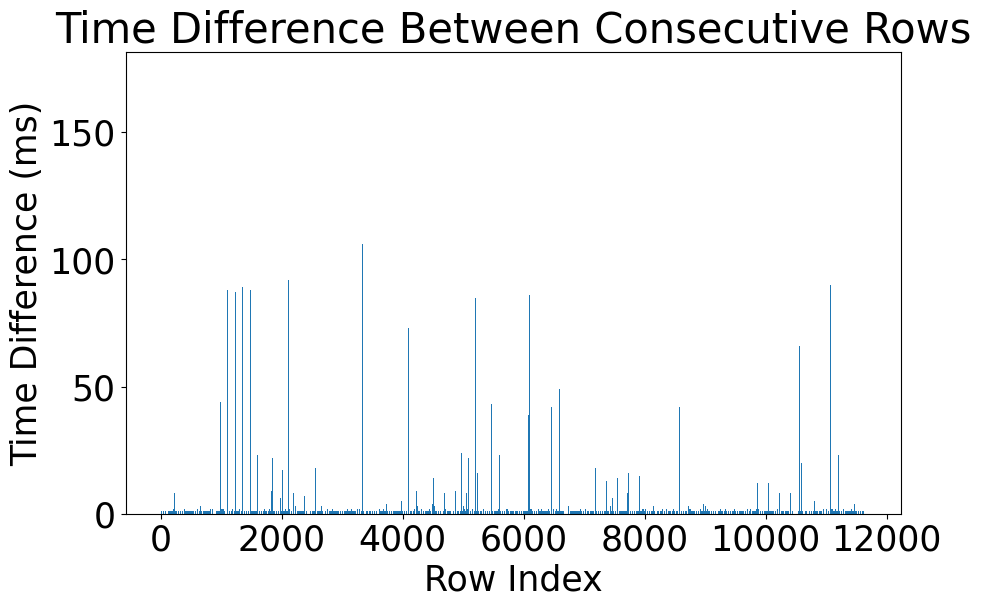

In [5]:
''' 
Here, we evaluate the recording behavior of my application. 

Please note that packets are generated by the Muse 
at set rates: 

MU_01 -> 220/500Hz depending on preset 

Other Muses -> 256Hz (or 128 for a special preset on the Athena)

Packets are NOT writen at a set rate by the receiving device however, 
and thus time between file lines will not be the same as the 
distance at which these measurements are taken by the 
Muse device.

'''

#file sampling rate: 
fs = 256
recording_time_sec = eeg_df_time_sec.max()
recording_time_ms = eeg_df["ms_ELAPSED"].max()

#expected number of samples
expected_sample_no = (fs/1000) * recording_time_ms

#expected time between writes
expected_interWrite_ms = 1000/fs

eeg_df.head()

''' 
checking distance between packets to identify recording issues.

Packets are written to file at an uneven rate by the recieving 
device, and so recording stalls do not always mean missed 
data. 
'''

# Calculate the difference between consecutive rows
eeg_df['ms_diff'] = eeg_df['ms_ELAPSED'].diff()


#Printing text representig our data characteristics 
print(f"Original dataframe shape: {df.shape}")
print(f"Optics-only dataframe shape: {eeg_df.shape}\n")

print(f"Total Recording time in ms: {recording_time_ms}")
print(f"Total Recording time in s: {recording_time_sec}")
print(f"Number of samples: {len(eeg_df)}\n")

print(f"Expected number of samples (ms precision): {expected_sample_no}\n")

#write stats 
print(f"Write Timing Stats: \n")
print(eeg_df['ms_diff'].describe())
print(f"\n")
#distance between writes based on fs
print(f"Expected Mean ms Between Writes : {expected_interWrite_ms}\n")
print(f"Actual Mean ms between: {eeg_df['ms_diff'].mean()}")
print(f"Max ms between: {eeg_df['ms_diff'].max()}")

# plot the differences 
plt.figure(figsize=(10, 6))
plt.plot(eeg_df.index, eeg_df['ms_diff'])
plt.xlabel('Row Index')
plt.ylabel('Time Difference (ms)')
plt.title('Time Difference Between Consecutive Rows')
plt.show()

# plot the differences as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(eeg_df.index, eeg_df['ms_diff'])
plt.xlabel('Row Index')
plt.ylabel('Time Difference (ms)')
plt.title('Time Difference Between Consecutive Rows')
plt.show()


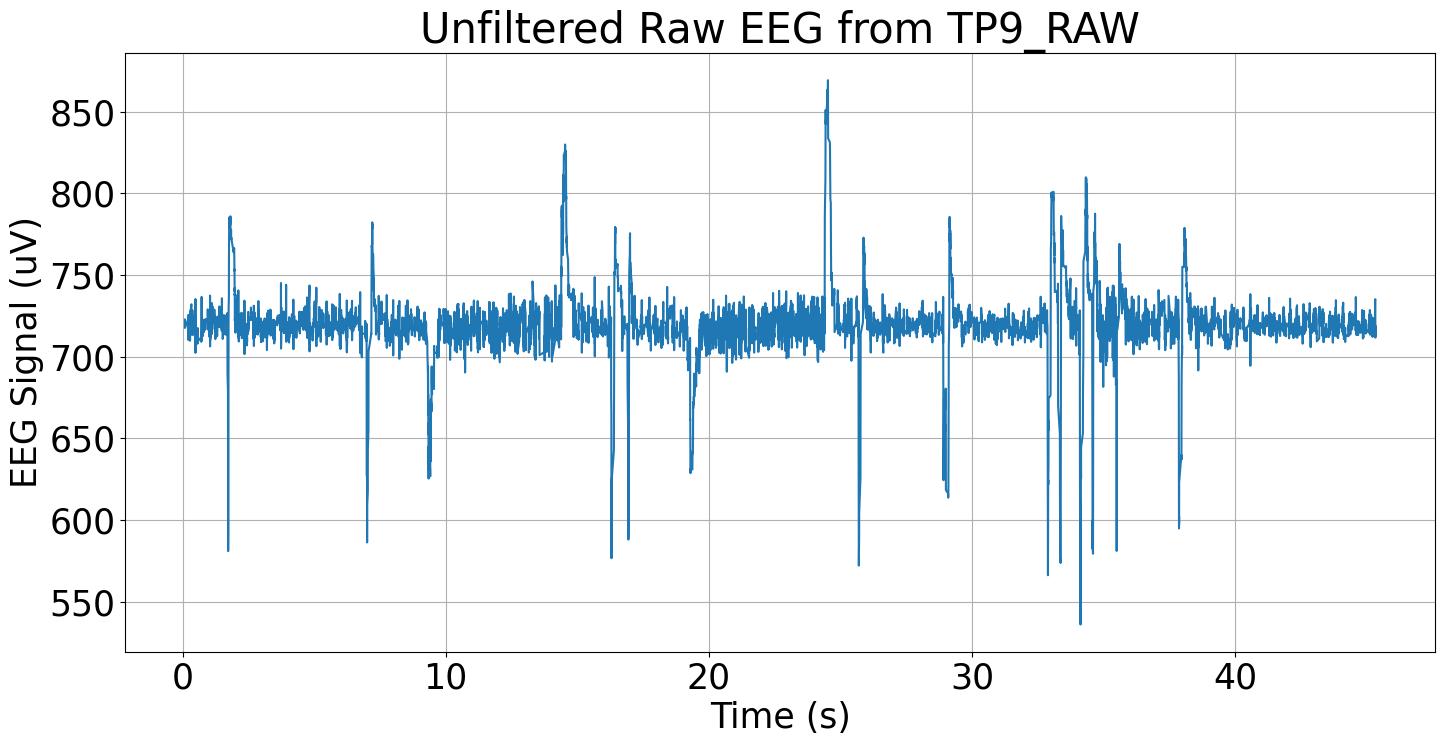

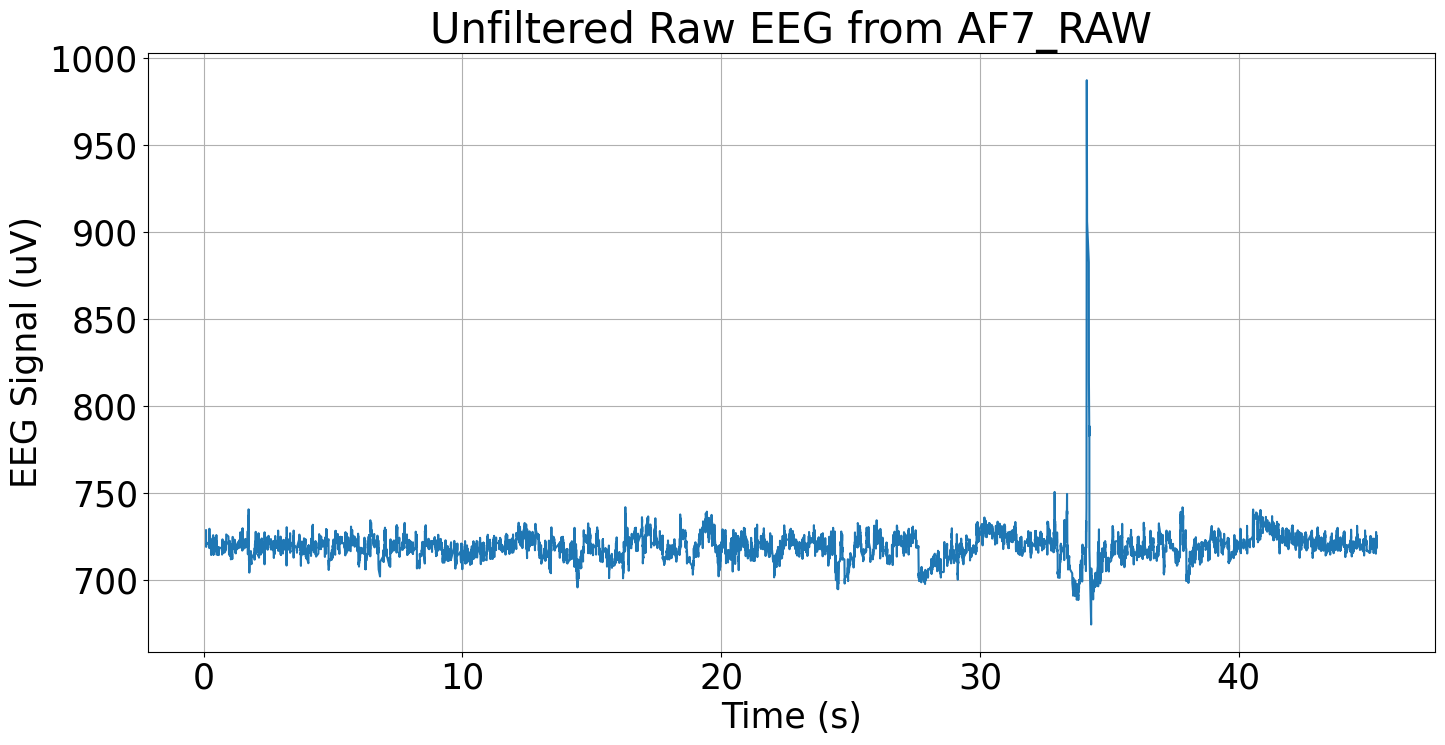

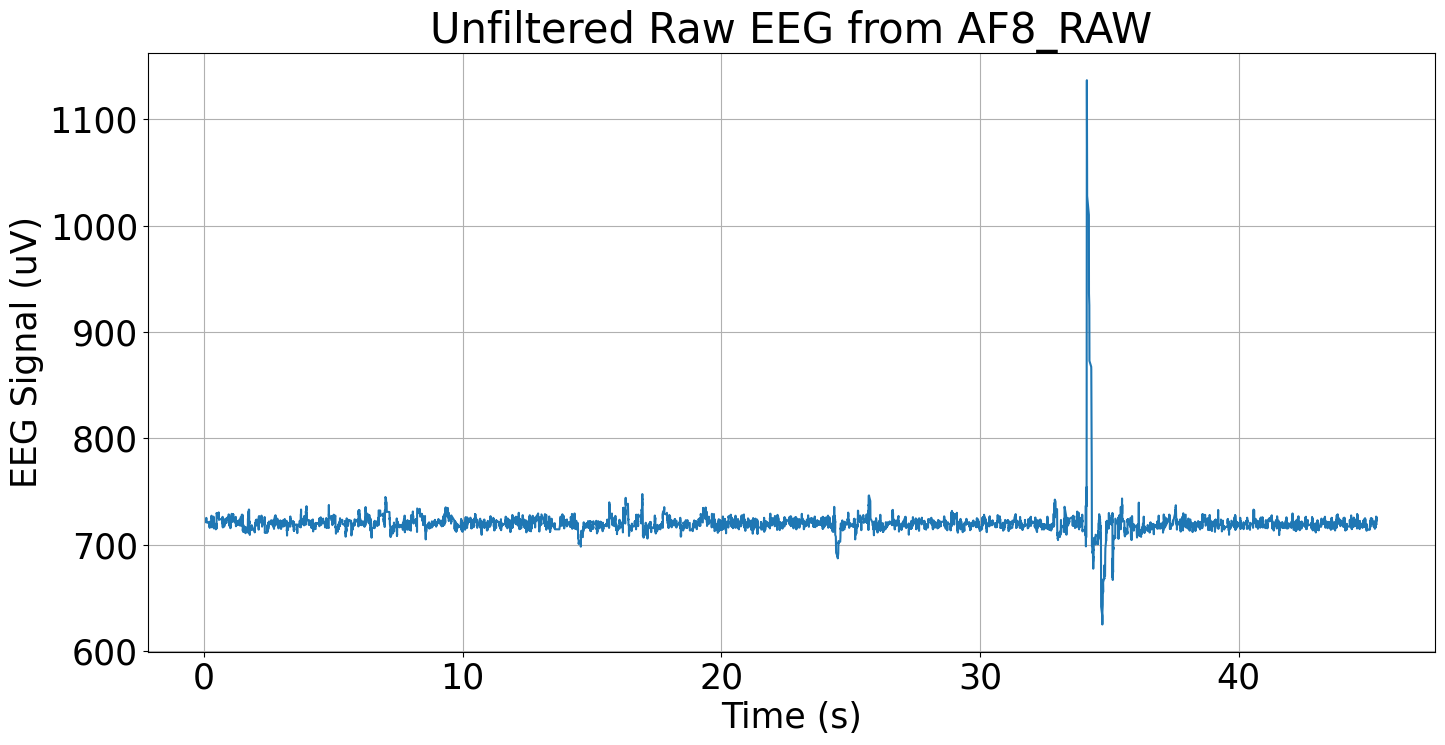

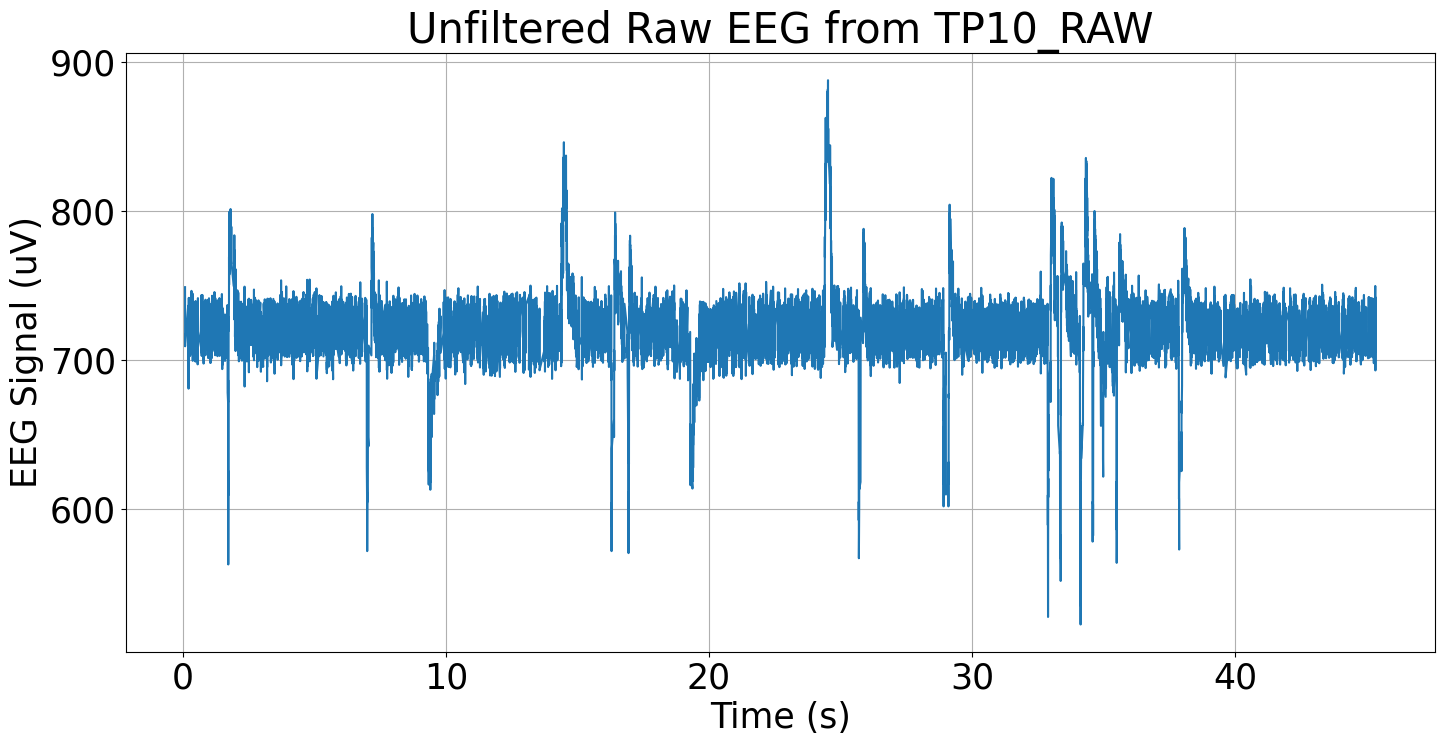

In [6]:
'''
Graphing the raw EEG data 
'''

channels = ["TP9_RAW", "AF7_RAW", "AF8_RAW", "TP10_RAW"]

for ch in channels:

    plt.figure(figsize=(15, 8))
    #plt.plot(time_sec, df[ch], label=ch)
    plt.plot(eeg_df_time_sec, eeg_df[ch] , label=ch)

    #plt.ylim(500,900)
    #plt.xlim(0,30)

    plt.xlabel("Time (s)")
    plt.ylabel("EEG Signal (uV)")
    plt.title(f"Unfiltered Raw EEG from {ch}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

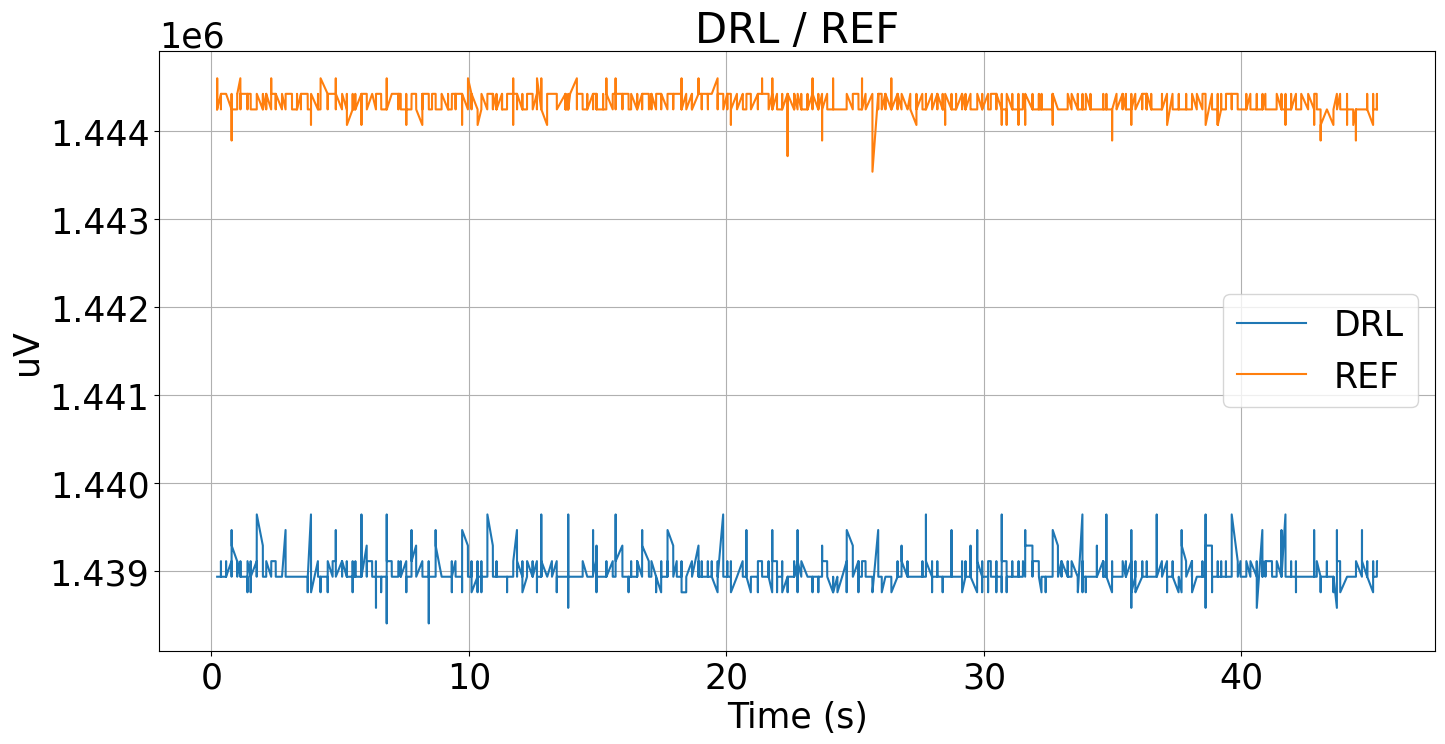

In [7]:
''' 
Graphing the DRL (Driven Right Leg, electrode at FPz ) and REF (Reference, at FP1 and FP2)
'''

#DRL_REF df 
DRL_REF_df = df[df['PACKET_TYPE'] == 'DRL_REF'][['ms_ELAPSED', 'DRL', 'REF']].copy()

#get time in seconds of  df
DRL_REF_df_time_sec = DRL_REF_df["ms_ELAPSED"] / 1000.0

# Reset index for clean indexing
DRL_REF_df = DRL_REF_df.reset_index(drop=True)

plt.figure(figsize=(15, 8))
plt.plot(DRL_REF_df_time_sec , DRL_REF_df['DRL'], label="DRL")
plt.plot(DRL_REF_df_time_sec , DRL_REF_df['REF'], label="REF")

plt.xlabel("Time (s)")
plt.ylabel("uV")
plt.title(f"DRL / REF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Number of samples: 11648
Channel: TP9_RAW
Number of samples - time_sec: 11648, filtered_data: 11648
filtered_data range: -150.27043978777016 to 143.4121388628263


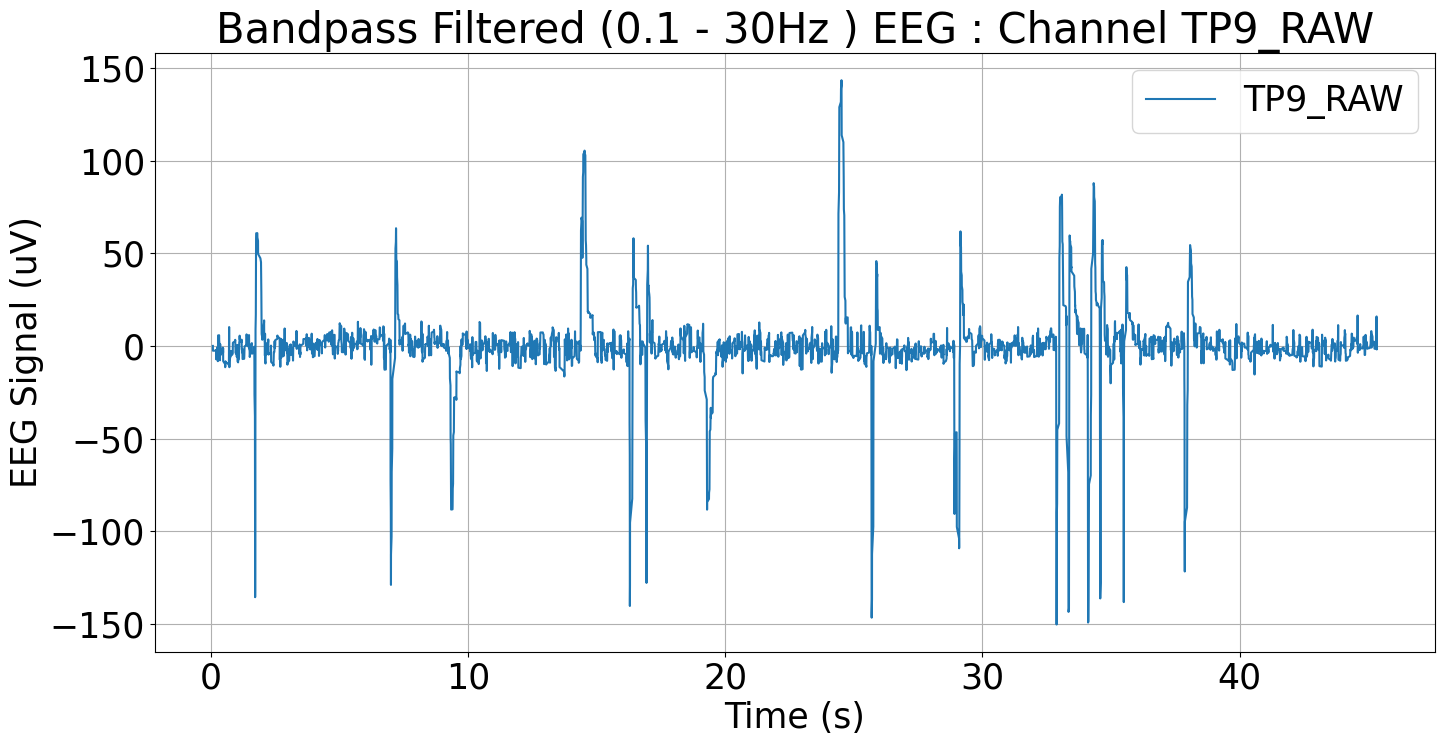

Number of samples: 11648
Channel: AF7_RAW
Number of samples - time_sec: 11648, filtered_data: 11648
filtered_data range: -29.57224770926725 to 256.8180772512749


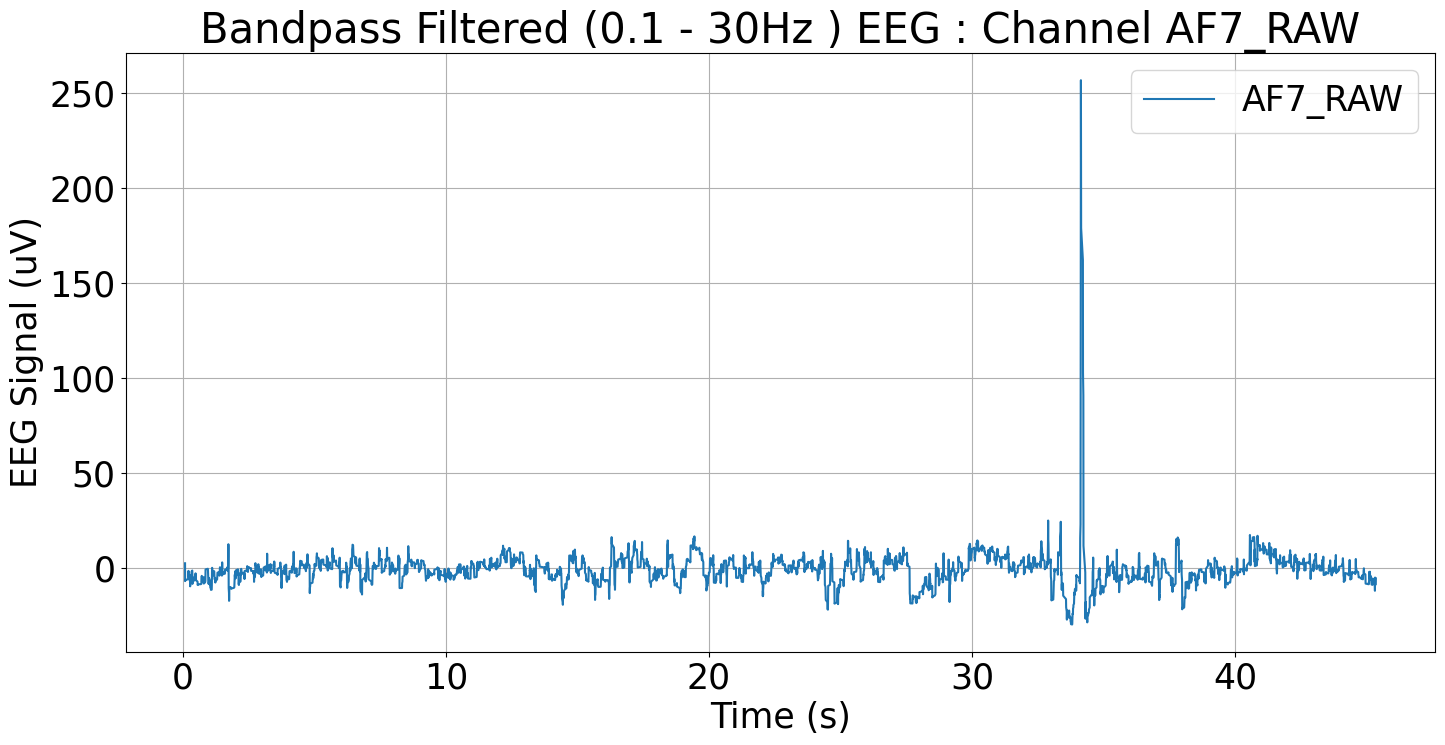

Number of samples: 11648
Channel: AF8_RAW
Number of samples - time_sec: 11648, filtered_data: 11648
filtered_data range: -94.12431384535456 to 407.3808736166522


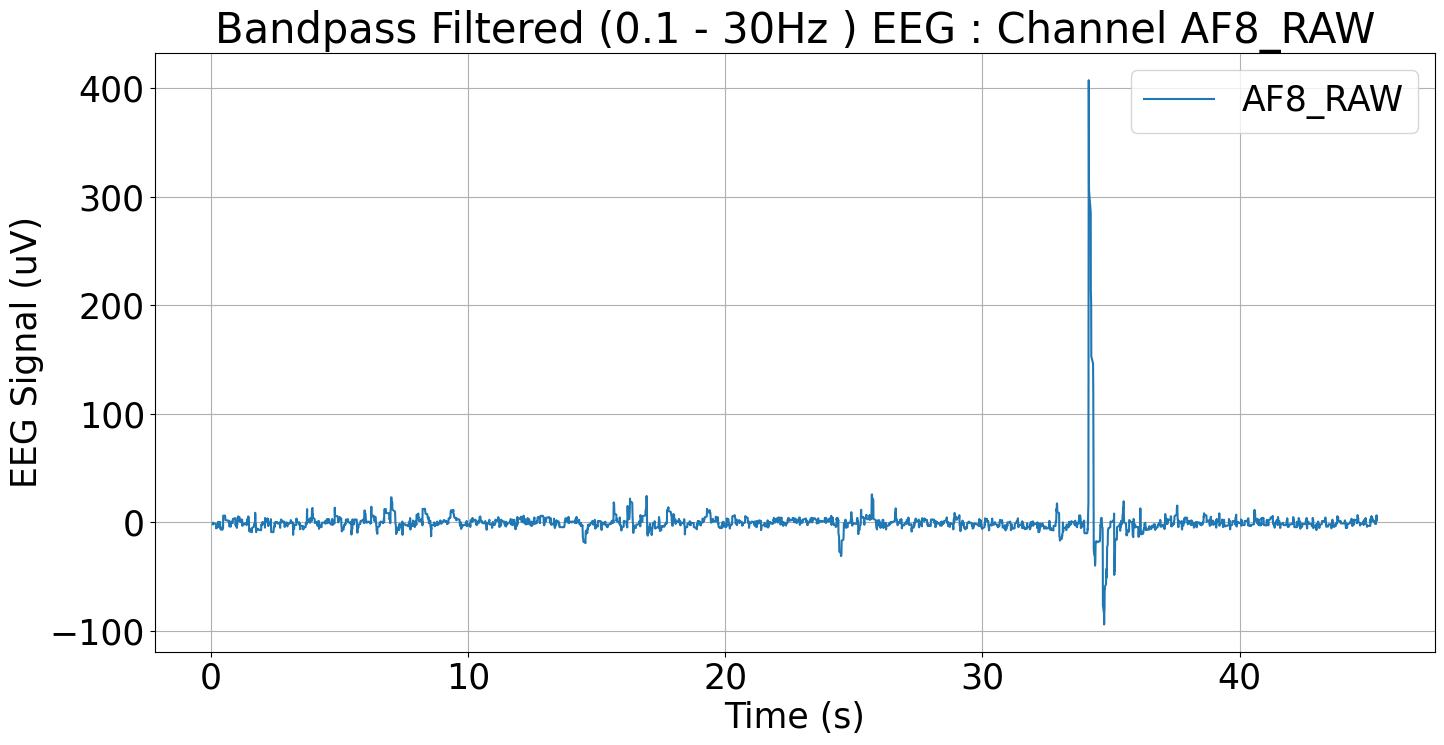

Number of samples: 11648
Channel: TP10_RAW
Number of samples - time_sec: 11648, filtered_data: 11648
filtered_data range: -160.30359878280436 to 149.93566463275303


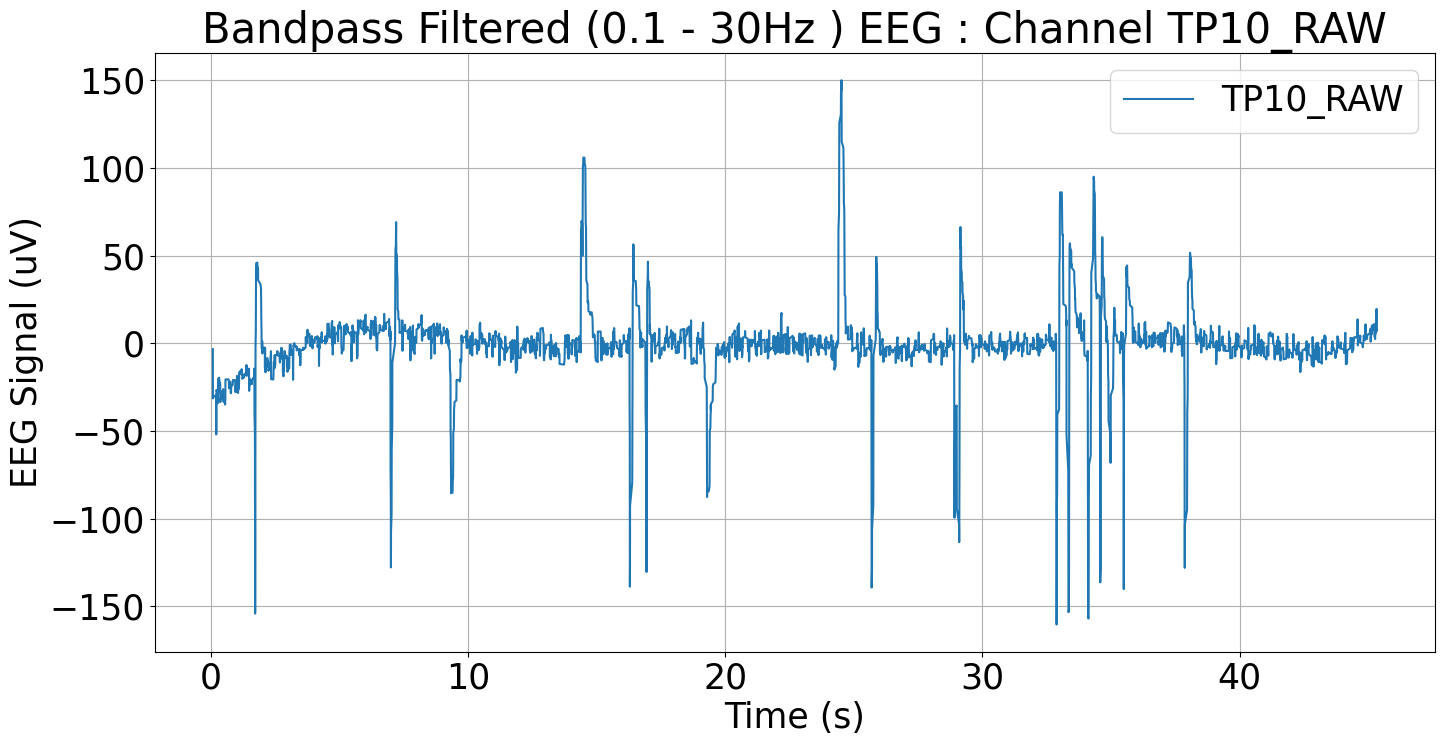

In [8]:
'''
Using a 0.1-30Hz Butterworth bandpass filter. 

Filtering from the eeg data that is extracted by packet type

Standard in neuroscience research: 
https://neuraldatascience.io/7-eeg/erp_filtering.html 
'''

time_sec = eeg_df["ms_ELAPSED"] / 1000.0
channels = ["TP9_RAW", "AF7_RAW", "AF8_RAW", "TP10_RAW"]

filtered_data = pd.DataFrame(columns = channels)

#loading filtered datain by channel
for ch in channels:

    # Define filter parameters
    lowcut = 0.1  # High-pass cutoff frequency
    highcut = 30   # Low-pass cutoff frequency
    sfreq = 500    #sampling freq
    order = 4      # Filter order

    # Calculate Nyquist frequency - for us sfreq/3
    nyquist_freq = sfreq/3

    # Normalize cutoff frequencies
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq

    # Design the Butterworth band-pass filter
    sos = butter(order, [low, high], btype='bandpass', output='sos')

    # Apply the filter using sosfiltfilt for zero-phase filtering
    filtered_data[ch] = sosfiltfilt(sos, eeg_df[ch])


#graphing the butterworth filtered data
for ch in channels:

    print(f"Number of samples: {len(filtered_data[ch])}")

    print(f"Channel: {ch}")
    print(f"Number of samples - time_sec: {len(time_sec)}, filtered_data: {len(filtered_data[ch])}")
    print(f"filtered_data range: {filtered_data[ch].min()} to {filtered_data[ch].max()}")

    plt.figure(figsize=(15, 8))
    plt.plot(time_sec, filtered_data[ch], label=ch)

    plt.xlabel("Time (s)")
    plt.ylabel("EEG Signal (uV)")
    plt.title(f"Bandpass Filtered (0.1 - 30Hz ) EEG : Channel {ch}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

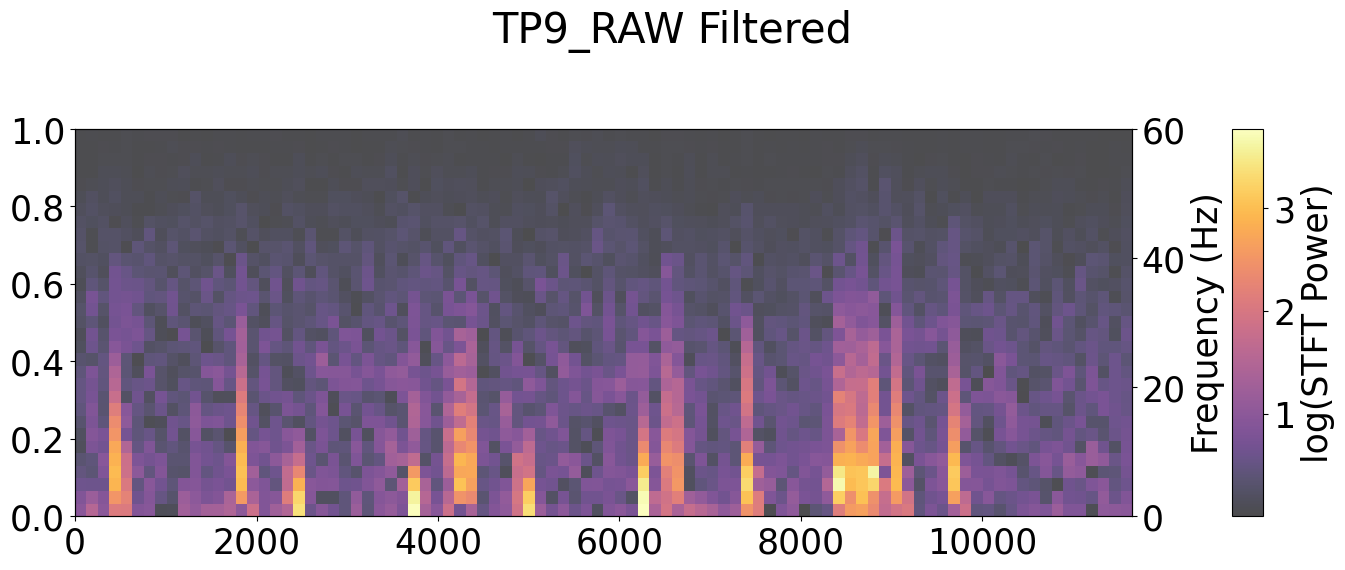

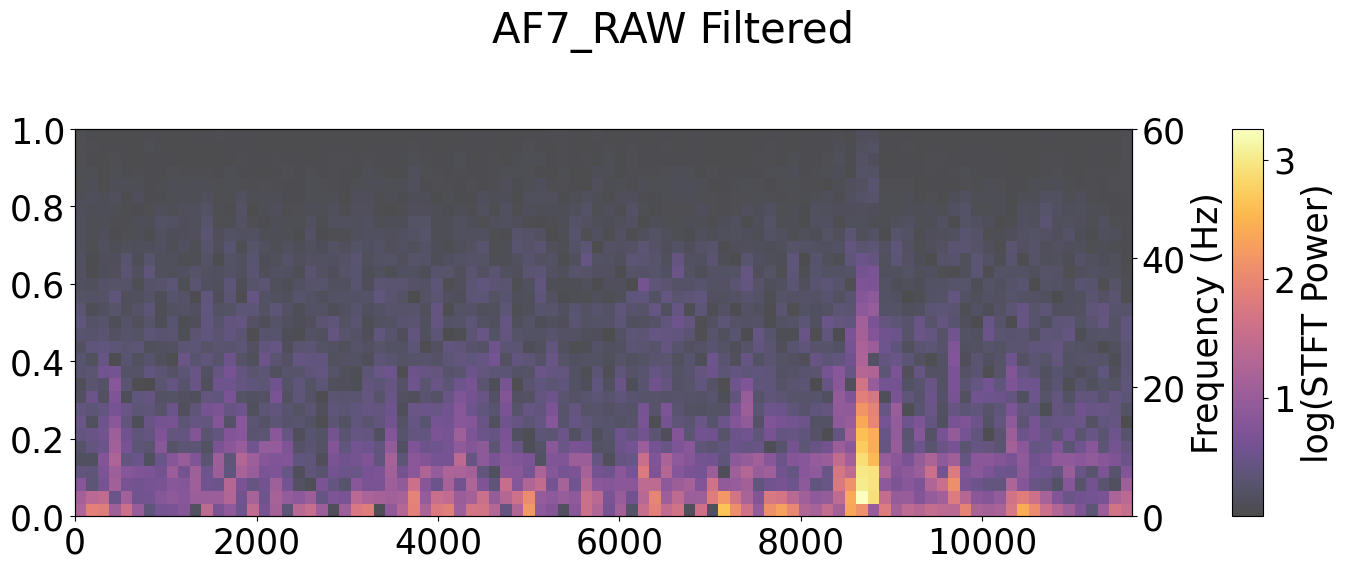

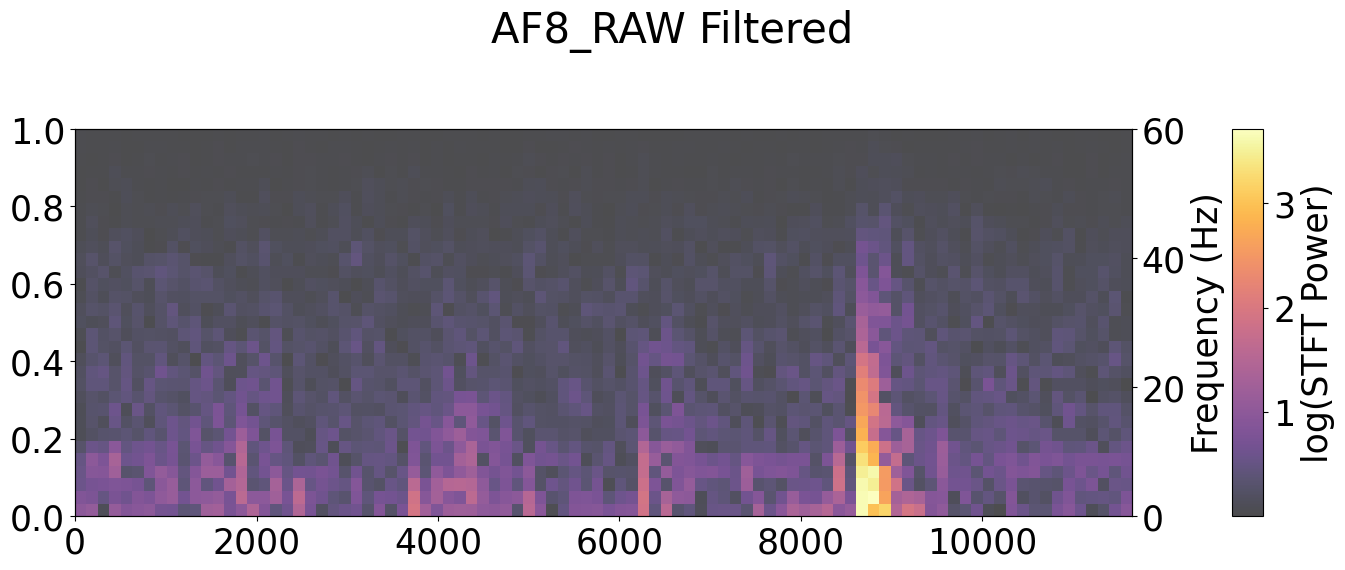

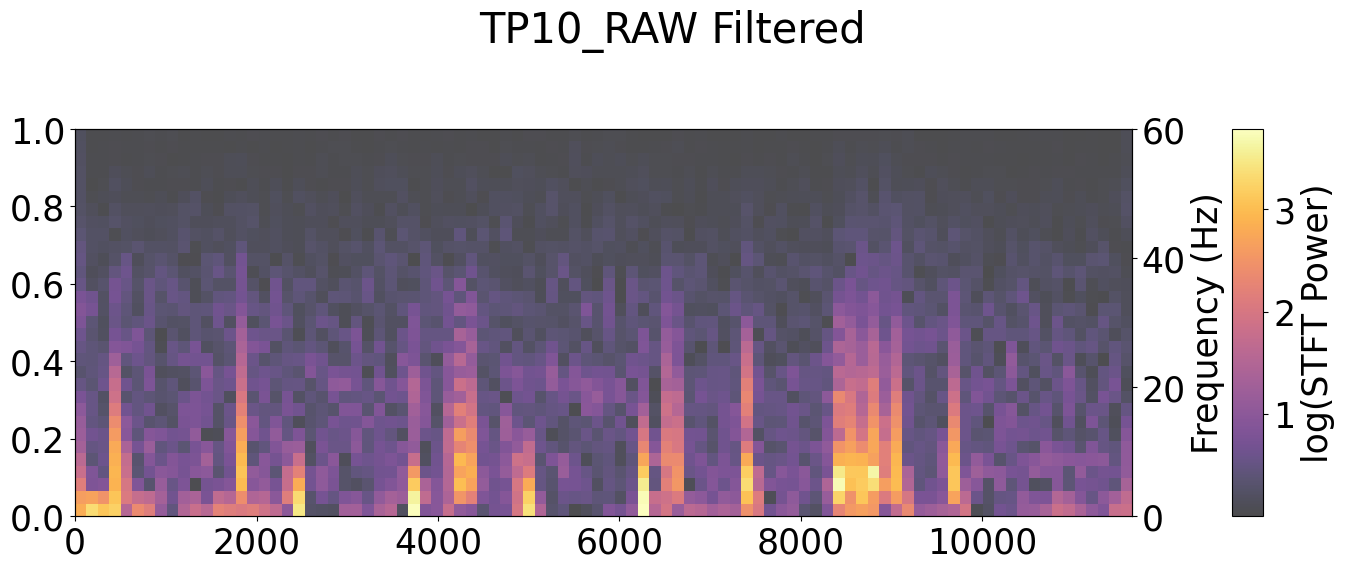

In [9]:
'''
Filtered STFT - Work in Progress!

working with the filtered data taken from lines where packet type is EEG

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html

'''

for ch in channels: 

    # Use a representative channel from the Muse data and apply STFT
    #swapping our df row for filtered data
    channel_idx = filtered_data.columns.get_loc(ch)

    nperseg = 256 #nperseg  - Same as sampling rate for testing, need to find good way of deciding this 
    freq_max = 60 #Max Freq 

    f, t, Zxx = stft(filtered_data[ch], fs=sfreq, nperseg=nperseg)

    global_t = t * sfreq 

    power = npy.abs(Zxx) #Zxx into absolute values  
    power_log = npy.log1p(power)  # log transform for better contrast

    #plotting the graph 
    fig, ax2 = plt.subplots(figsize=(14, 6))

    ax1 = ax2.twinx()
    extent = [global_t[0], global_t[-1], 0, freq_max]
    im = ax1.imshow(power_log[f <= freq_max, :], extent=extent, aspect='auto',
                    origin='lower', cmap='inferno', alpha=0.7)
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_ylim(0, freq_max)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="3%", pad=1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('log(STFT Power)')

    plt.suptitle( (ch + " Filtered") , ha='center')
    fig.tight_layout()
    plt.show()

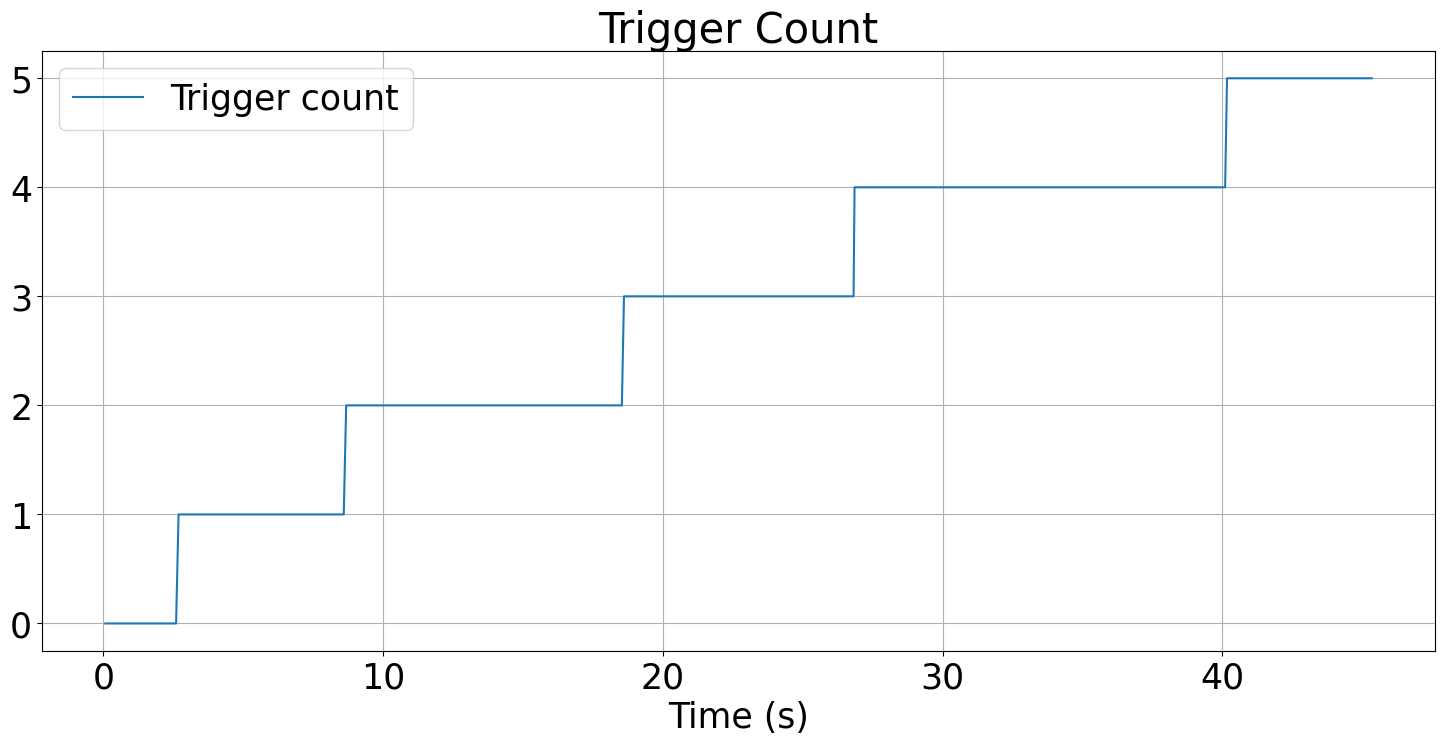

In [10]:
'''
Trigger Count - User press 
'''

time_sec = df["ms_ELAPSED"] / 1000.0

plt.figure(figsize=(15, 8))
plt.plot(time_sec, df['TRIGGER_COUNT'], label="Trigger count")

plt.xlabel("Time (s)")
plt.title(f"Trigger Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

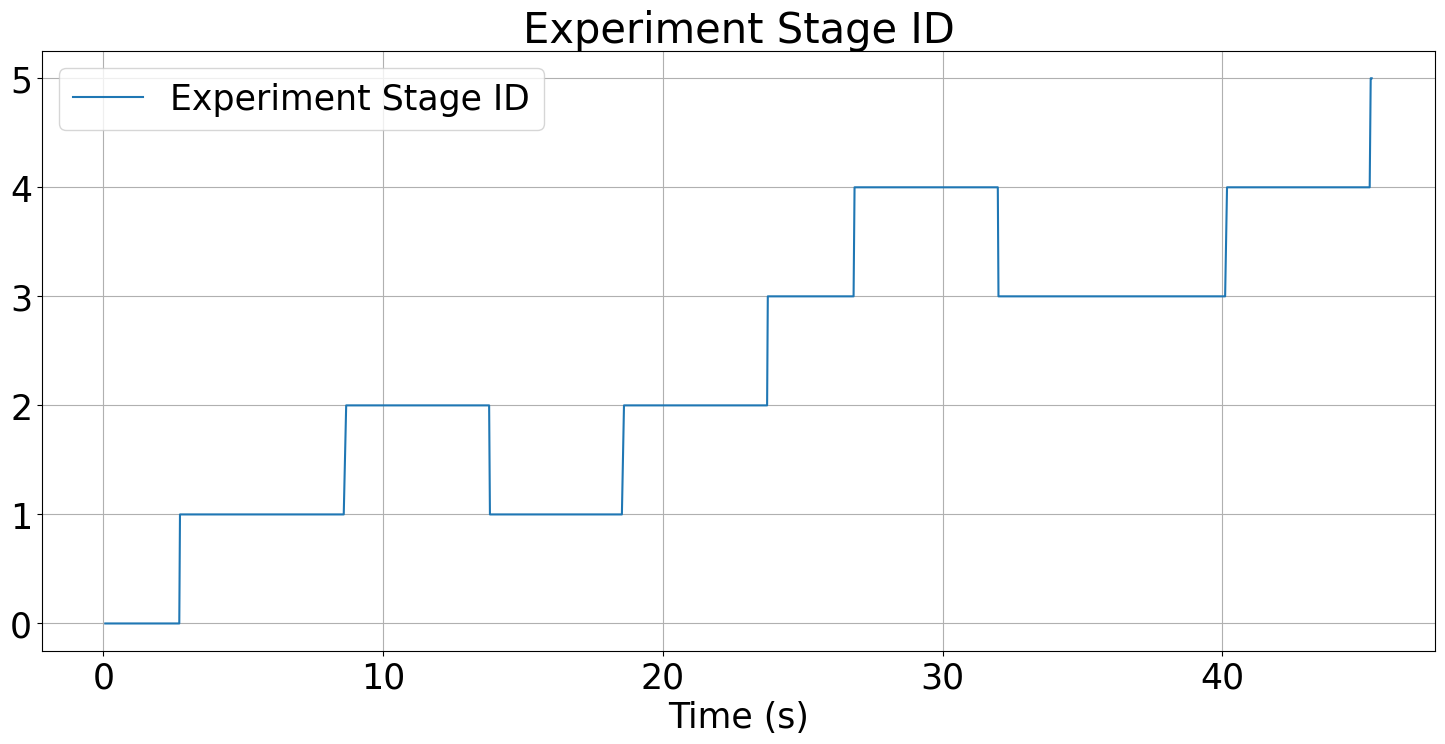

In [15]:
'''
Trigger Stages
'''

time_sec = df["ms_ELAPSED"] / 1000.0

plt.figure(figsize=(15, 8))
plt.plot(time_sec, df['EXPERIMENT_STAGE'], label="Experiment Stage ID")

plt.xlabel("Time (s)")
plt.title(f"Experiment Stage ID")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

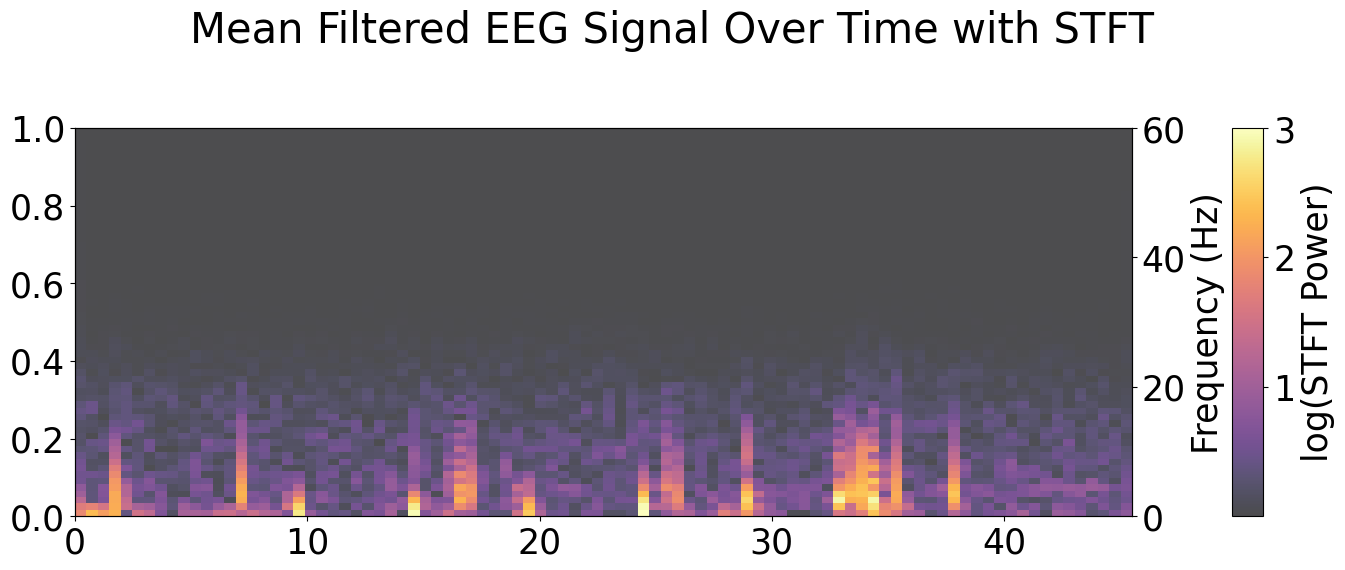

In [12]:
''' 
Filtered avg STFT
'''
fs = 256  #Muse uses 256Hz
eeg_mean = filtered_data[channels].mean(axis=1).values

nperseg = 256
freq_max = 60  #Relevant bands

f, t, Zxx = stft(eeg_mean, fs=fs, nperseg=nperseg, boundary='zeros')
power = npy.abs(Zxx)
power_log = npy.log1p(power)  # log transform for visibility
time_stft_sec = t  # t is already in seconds

fig, ax2 = plt.subplots(figsize=(14, 6))

ax1 = ax2.twinx()
extent = [time_stft_sec[0], time_stft_sec[-1], 0, freq_max]
im = ax1.imshow(power_log[f <= freq_max, :], extent=extent, aspect='auto',
                origin='lower', cmap='inferno', alpha=0.7)
ax1.set_ylabel('Frequency (Hz)')
ax1.set_ylim(0, freq_max)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3%", pad=1)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('log(STFT Power)')

plt.suptitle("Mean Filtered EEG Signal Over Time with STFT")
fig.tight_layout()
plt.show()


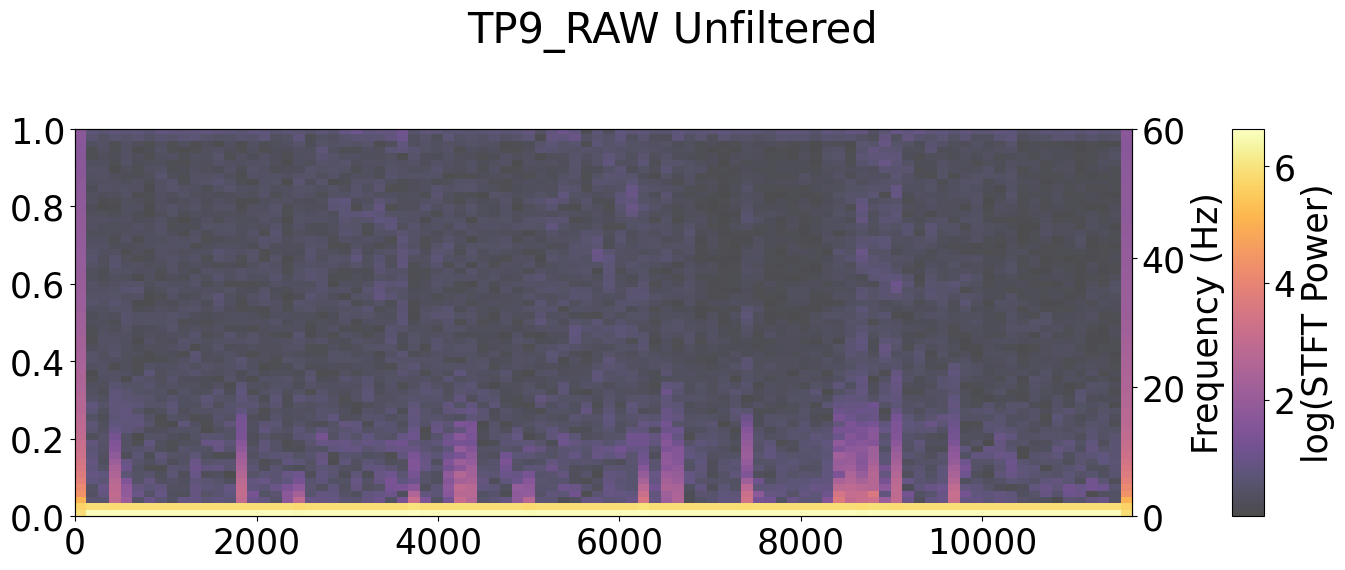

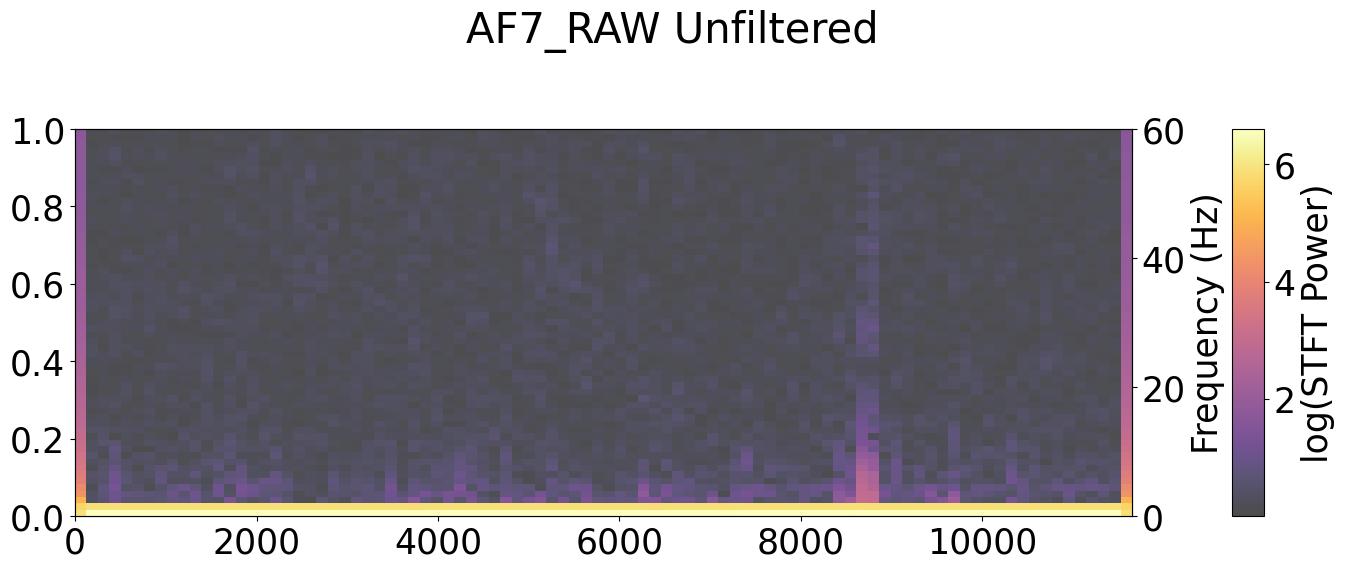

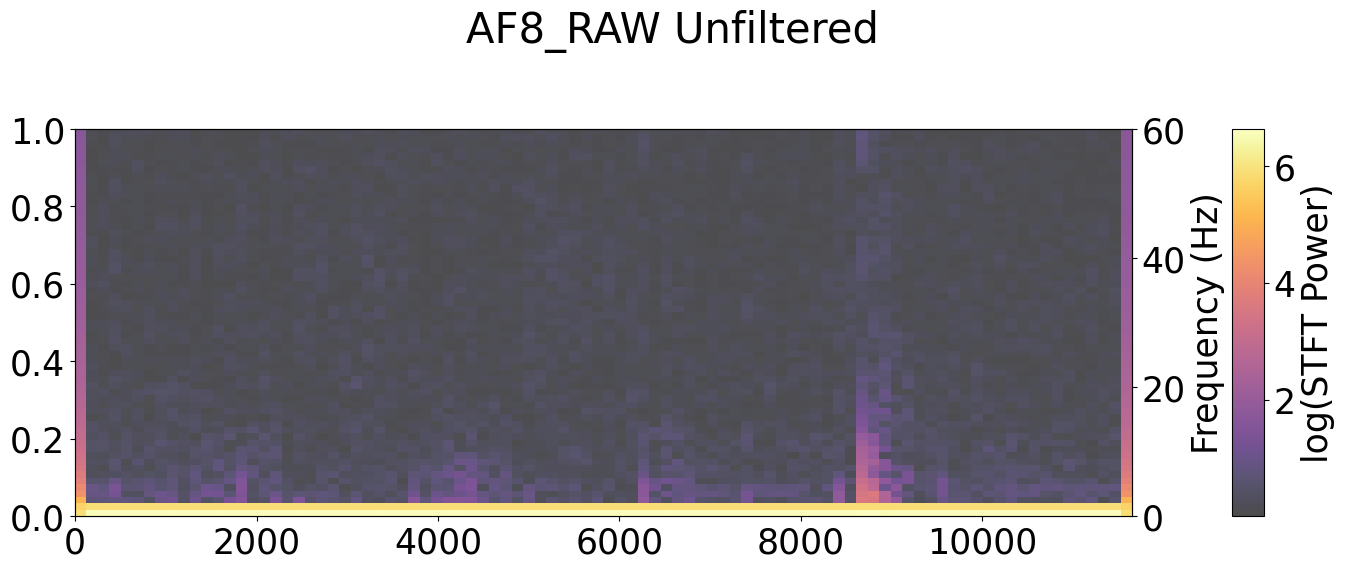

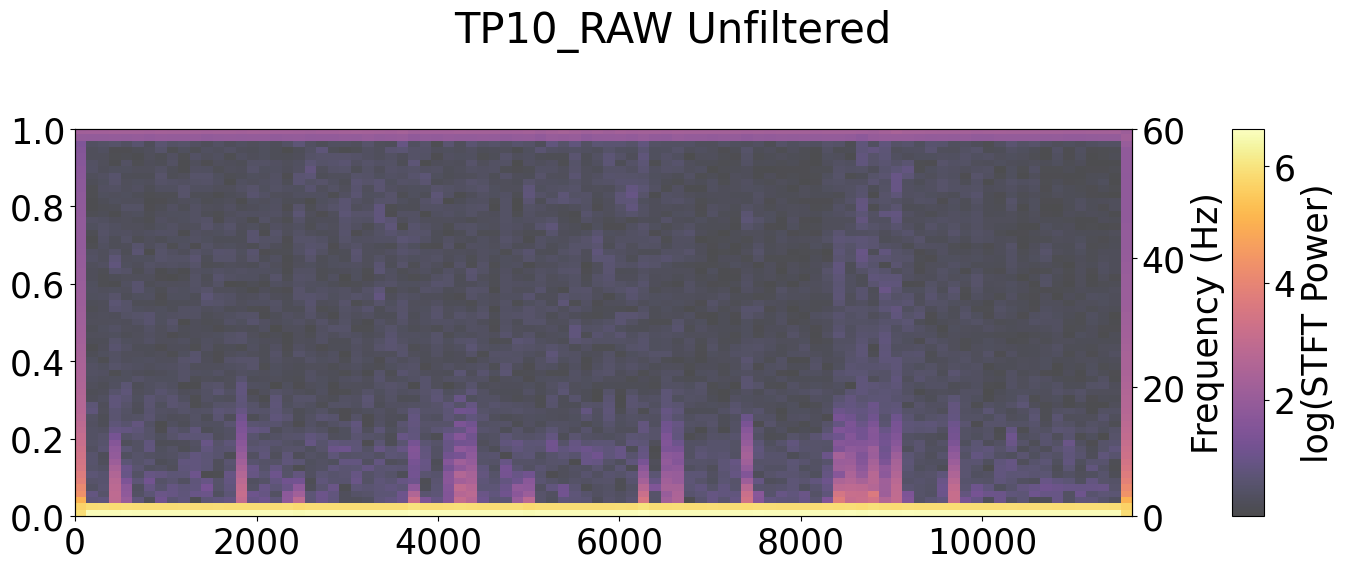

In [13]:
''' 
Unfiltered data STFT
'''

for ch in channels: 

    # Use a representative channel from the Muse data and apply STFT
    fs = 256  # sampling rate
    eeg = eeg_df[ch].values
    channel_idx = eeg_df.columns.get_loc(ch)

    nperseg = 256 #using sampling rate till I find a better way
    freq_max = 60

    f, t, Zxx = stft(eeg, fs=fs, nperseg=nperseg)
    power = npy.abs(Zxx)
    global_t = t * fs  # convert to sample index
    power_log = npy.log1p(power)  # log transform for better contrast

    fig, ax2 = plt.subplots(figsize=(14, 6))

    ax1 = ax2.twinx()
    extent = [global_t[0], global_t[-1], 0, freq_max]
    im = ax1.imshow(power_log[f <= freq_max, :], extent=extent, aspect='auto',
                    origin='lower', cmap='inferno', alpha=0.7)
    ax1.set_ylabel('Frequency (Hz)')
    ax1.set_ylim(0, freq_max)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="3%", pad=1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('log(STFT Power)')

    plt.suptitle(ch + ' Unfiltered', ha='center')
    fig.tight_layout()
    plt.show()


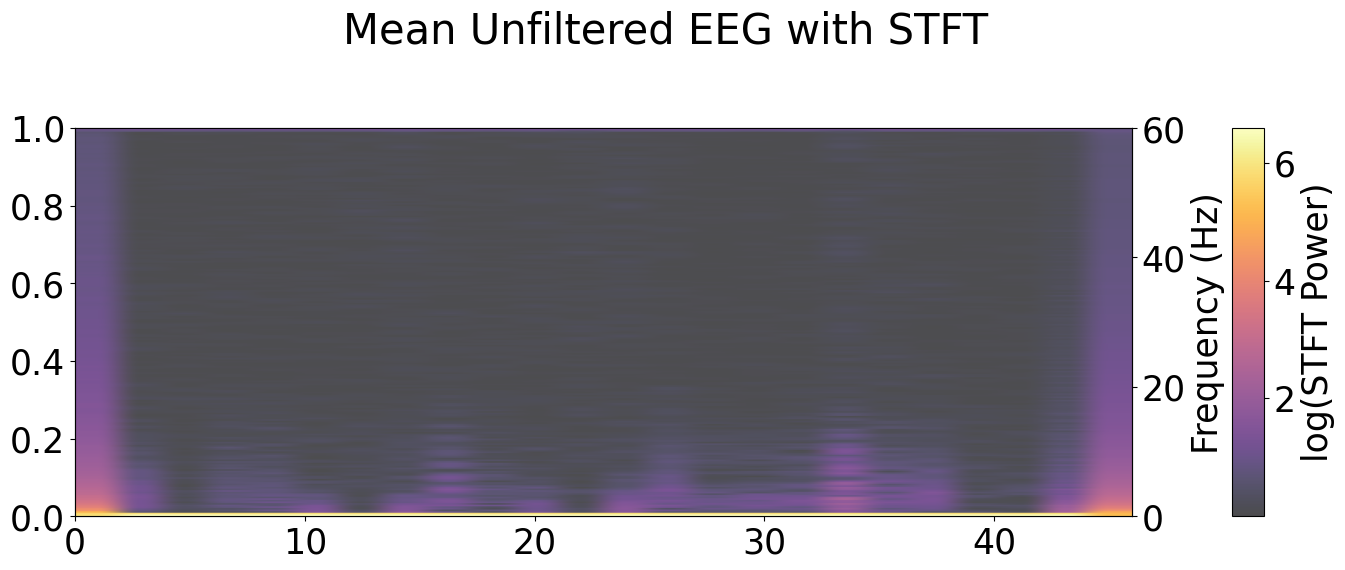

In [14]:
''' 
Unfiltered avg STFT (Work in Progress!)
'''

fs = 256  #Muse uses 256Hz
channels = ["TP9_RAW", "AF7_RAW", "AF8_RAW", "TP10_RAW"]
eeg_mean = eeg_df[channels].mean(axis=1).values

nperseg = 1024
freq_max = 60  #Relevant bands

f, t, Zxx = stft(eeg_mean, fs=fs, nperseg=nperseg, boundary='zeros')
power = npy.abs(Zxx)
power_log = npy.log1p(power)  # log transform for visibility
time_stft_sec = t  # t is already in seconds

fig, ax2 = plt.subplots(figsize=(14, 6))

ax1 = ax2.twinx()
extent = [time_stft_sec[0], time_stft_sec[-1], 0, freq_max]
im = ax1.imshow(power_log[f <= freq_max, :], extent=extent, aspect='auto',
                origin='lower', cmap='inferno', alpha=0.7)
ax1.set_ylabel('Frequency (Hz)')
ax1.set_ylim(0, freq_max)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3%", pad=1)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('log(STFT Power)')

plt.suptitle("Mean Unfiltered EEG with STFT ")
fig.tight_layout()
plt.show()
